<br>
<br>
<br>

<h1 align="center"> Admin waits for incoming research proposals </h1>
<img src="../CCAIO workshop imgs/steps/w.svg" style="width:100%"/><br>
<br>
<br>

<h1 align="center">Part 3</h1>

<h1 align="center">Admin responds to incoming questions</h1>

<center><img src="../CCAIO workshop imgs/steps/30.svg" align="center" style="width:90%"/></center>

This involves:
- review the incoming requests
- decide whether the requests are compliant with the admin's organisation requirements
- approve or deny accordingly each request

# 3.1. Rewiew of the research proposal and code
<center><img src="../CCAIO workshop imgs/steps/31.svg" align="center" style="width:90%"/></center>


In [ ]:
%%capture
import syft as sy

# Logging as admin to the server
admin_client = sy.login(url='localhost:8086', email='info@openmined.org', password='changethis')
admin_client

## Review research project proposal

In [18]:
project = admin_client.projects[0]
project

syft.service.project.project.Project

## Review each code request attached to the project proposal

#### First request: suggestiveness_in_top10pp_videos (fix)

In [19]:
request_1 = project.requests[0]
request_1.code

```python
class UserCode
    id: UID = fde66ad29673476582771117f0f965bf
    service_func_name: str = suggestiveness_in_top10pp_videos
    shareholders: list = ['dailymotion_node']
    status: list = ['Node: dailymotion_node, Status: pending']
    
    code:

@sy.syft_function_single_use(df=asset)
def suggestiveness_in_top10pp_videos(df):
    from opendp.measurements import make_base_laplace
    from opendp.mod import enable_features
    from io import BytesIO
    import numpy as np
    import matplotlib.pyplot as plt

    def most_popular_videos_in_dataset(data):
        # Select the top 10% of the videos by number of recommendations
        count_top10p = int(0.1 * data.size)
        top10_threshold = data['recommendations'].nlargest(count_top10p).iloc[-1].astype(float)  
        top_posts = data[data['recommendations'] > top10_threshold]
        return top_posts

    # Select most popular videos (top 10%)
    top_posts = most_popular_videos_in_dataset(df)
    top_posts_per_algo = [most_popular_videos_in_dataset(df[df['algo'] == x]) for x in ['A', 'B', 'C']]
    
    # Adding DP noise    
    enable_features("contrib")
#     base_lap_vec_sugg = make_base_laplace(scale=1e-4, D="VectorDomain<AllDomain<float>>")

    to_plot = [x['suggestive'].to_list() for x in [df, top_posts] + top_posts_per_algo]
#     to_plot = [base_lap_vec_sugg(x['suggestive'].to_list()) for x in [df, top_posts] + top_posts_per_algo]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12,8))
    bp = ax.boxplot(to_plot, sym='k+', positions=np.arange(len(to_plot)) + 1, vert=True, patch_artist=True, notch=True)

    colors = ['pink', 'lightblue', 'lightgreen', 'lavender']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.yaxis.grid(True)
    ax.set_title('Most popular videos\' sugestiveness', size=18)
    ax.set_ylabel('Suggestiveness ', fontsize=16)
    ax.set_xticks(range(7),['', 'All videos', 'Top posts', 'Top posts Alg.1', 'Top posts Alg.2', 'Top posts Alg.3', ''], size=14)

    figfile = BytesIO()
    plt.savefig(figfile, format='png')
    return figfile

```

The code is compliant with the data use/mis-use policies set before:
- releases aggregate statistics using differential noise
- does not release information about any individual

#### Second request: get_outliers

The 2nd request releases a very small sample (~10-20) of the videos, flagged to be considered outliers. 

In [ ]:
request_2 = project.requests[1]
request_2.code

```python
class UserCode
    id: UID = b371175a3dc1474c98ee8f9c7e67eaa5
    service_func_name: str = get_outliers
    shareholders: list = ['dailymotion_node']
    status: list = ['Node: dailymotion_node, Status: pending']
    
    code:

@sy.syft_function_single_use(df=asset)
def get_outliers(df, x_axis = 'suggestive', y_axis = 'recommendations', category_seriesname = 'algo', threshold = 6):
    import numpy as np
    import pandas as pd
    from sklearn.covariance import MinCovDet

    # Pick out outliers per category
    categories = sorted(df[category_seriesname].unique())
    results = []
    for category_label in categories:
        df_outliers = df[df[category_seriesname] == category_label]
        X = df_outliers[[x_axis, y_axis]].to_numpy()


        # fit a MCD robust estimator to data
        robust_cov = MinCovDet().fit(X)

        # Outliers
        df_outliers = df_outliers[df_outliers[x_axis] > robust_cov.location_[0]]
        df_outliers = df_outliers[df_outliers[y_axis] > robust_cov.location_[1]]

        # Filter for data in the upper right quadrant
        X = X[np.logical_and(X[:,0] > robust_cov.location_[0], X[:,1] > robust_cov.location_[1])]

        # Compute Mahalanobis distance (squared)
        df_outliers['distance'] = robust_cov.mahalanobis(np.c_[df_outliers[x_axis].to_numpy(),
                                        df_outliers[y_axis].to_numpy()])

        # Only consider points exceeding the threshold number of standard deviations
        df_outliers = df_outliers[df_outliers['distance'] > threshold]

        results.append(df_outliers)
    
    df_results = pd.concat(results)
    
    # Sort by Mahalanobis distance
    df_results = df_results.sort_values('distance', ascending=False)
    
    return df_results

```


However, releasing directly a sample of videos, including metrics like impressions and toxicity, could posses a few risks:
- **Impact on content creators**: the videos flagged as suggestive, yet promoted by the algorithms, could stigmatize content creators
- **Privacy and consent**: the video released might have been *privately shared* or *password-protected*, meaning the creator has not directly content to sharing the video information with other parties
- **Privacy and consent**: the impressions amount is not public information on the platform, but could imply the monetary outcome.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Open Governance Question</p>
    Is it ethical to release such a very small scale sample, given the above risks for the platform users, to advance our understanding of algorithms?</div>

### Our perspective (UNDECIDED, might be skipped)

<div class="admonition alert alert-info">
    The above request will be denied. The protection of the platform's users remains the main priority of the company and auditees.</div>

## 2.2 Execute and test the code

<center><img src="../CCAIO workshop imgs/steps/32.svg" align="center" style="width:90%"/></center>

We will execute only the first request, since we deny the second.

SyftWarning: This code was submitted by a User and could be UNSAFE.

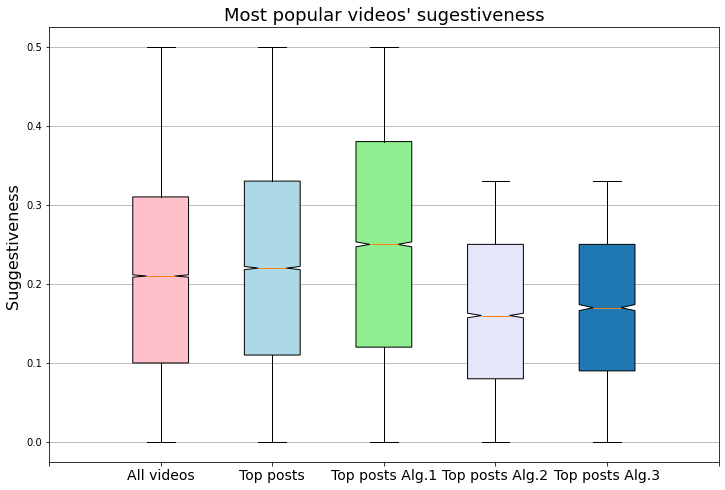

In [21]:
request_1.code.unsafe_function(df=admin_client.datasets[0].assets[0].mock)

## 2.3 Submits the final answer back to all requests

<center><img src="../CCAIO workshop imgs/steps/33.svg" align="center" style="width:90%"/></center>


### Responding to each...

In [22]:
# Approve the first
request_1.approve()

Request approved for domain dailymotion_node


SyftSuccess: Request f8f50ea723c9473ca0b31c7302ce7215 changes applied

In [23]:
# Deny the second
request_2.deny(reason="This request requires releasing a subsample of the impression data and video metadata, which could put the privacy of ouru")

SyftSuccess: Request 9164b91ef80b4b3bba4303aade904b50 successfully denied !

In [24]:
admin_client.requests

<br>
<br>

<h1 align="center"> Admin waits to review the findings</h1>
<img src="../CCAIO workshop imgs/steps/w.svg" style="width:100%"/><br>

<br>
<br>